<a href="https://colab.research.google.com/github/CocoaSpice/china-dictatorship/blob/baseline/RSNA_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# Mount to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
# Authenticate GCP
#from google.colab import auth
#auth.authenticate_user()

#project_id = 'rsna-326901'
#! gcloud config set project {project_id}
#! gsutil ls

In [33]:
# Import data
#bucket_name = 'rsna_preprocessed'
#!gsutil -m cp -r gs://{bucket_name}/ /content/drive/My\ Drive/Data

# Prepare dataset

In [9]:
# Import packages
import os
import glob
import csv
import sys
import time
from tqdm import tqdm

import math
import random
import numpy as np

import cv2
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

import albumentations

In [10]:
# Load train_labels.csv
csv_path = '/content/drive/MyDrive/Data/rsna_preprocessed/train_labels.csv'

train_labels = pd.read_csv(csv_path)
train_labels

,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1
...,...,...
580,1005,1
581,1007,1
582,1008,1
583,1009,0


In [11]:
!pip install -q torchio

In [26]:
import torchio as tio
root_dir = '/content/drive/MyDrive/Data/rsna_preprocessed'

# Load train_set and assign input_size
transform = tio.Compose([tio.CropOrPad((251, 251, 150)),
                         tio.RescaleIntensity(out_min_max=(0, 1)),])


train_set = tio.datasets.RSNAMICCAI(root_dir, train=True, transform=transform)

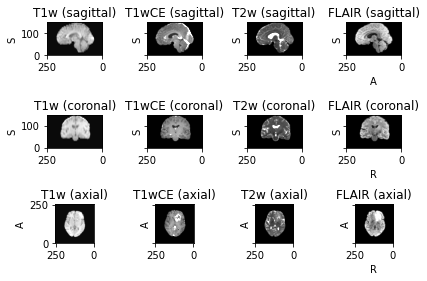

In [13]:
subject = train_set[0]
subject.plot()

In [27]:
# Split up train_set to train and val
from torch.utils.data import random_split

# Practice mode
split_ratio = 0.9
n_train_set = int(len(train_set) * split_ratio)
n_val_set = len(train_set) - n_train_set

train_set, val_set = random_split(train_set,
                                  [n_train_set, n_val_set],
                                  generator=torch.Generator().manual_seed(1))

print(len(val_set))

59


In [28]:
# Practice mode: retrieve 10% for each of train_set and val_set
train_set, val_set = random_split(val_set,
                            [51, 8],
                            generator=torch.Generator().manual_seed(1))

In [29]:
# Generate dataloaders
batch_size = 4

train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size=batch_size,
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(val_set,
                                         batch_size=batch_size,
                                         shuffle=False)

print(len(train_loader))
print(len(val_loader))

13
2


# Import EfficientNet-3D

In [17]:
!pip install git+https://github.com/shijianjian/EfficientNet-PyTorch-3D

  Cloning https://github.com/shijianjian/EfficientNet-PyTorch-3D to /tmp/pip-req-build-k0ux77u9
  Running command git clone -q https://github.com/shijianjian/EfficientNet-PyTorch-3D /tmp/pip-req-build-k0ux77u9
  Created wheel for efficientnet-pytorch-3d: filename=efficientnet_pytorch_3d-0.6.3-py3-none-any.whl size=16770 sha256=b2e43f1c5a965a77f5bb736e33d91a8b8715eae661a4823a6e4370b1710cf26a
  Stored in directory: /tmp/pip-ephem-wheel-cache-0ujpb80b/wheels/ea/44/3d/89ce0e32ed262cff6c10d0586dc8f82bbb8ba1eeb47863abe5
Successfully built efficientnet-pytorch-3d


In [18]:
from efficientnet_pytorch_3d import EfficientNet3D

model = EfficientNet3D.from_name("efficientnet-b0", override_params={'num_classes': 1}, in_channels=1)
model.cuda()

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

In [19]:
# Loss function and optimizer
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

# Import sklearn ROC_AUC score
from sklearn.metrics import roc_auc_score

# Training

In [20]:
def train(epochs, scan_type):

  # Generate lists for tracking training stats
  ls_train_loss = []
  ls_val_loss = []

  # Training
  for epoch_i in range(epochs):
    print('【 Epoch {}/{} 】'.format(epoch_i+1, epochs))
    print(' Training phase...')

    # Reset train_loss
    train_loss = 0
    
    # Set training mode
    model.train()

    for batch in tqdm(train_loader):

      # reset optimizer
      optimizer.zero_grad()

      # Get input array
      input = batch[scan_type]['data'].float().to(device)

      # Feed to the model and get logit
      logits = model(input).squeeze()
      labels = batch['MGMT_value'].float().to(device)
      
      # Loss function
      loss = loss_fn(logits, labels)
      loss.backward()

      # Optimizer
      optimizer.step()

      # Update train loss
      train_loss += loss.item()

    # Train stats of this epoch
    avg_train_loss = train_loss/len(train_loader)
    print('  Avg. train loss: {:.4f}'.format(avg_train_loss))
    print('\n')

    print(' Validation phase...')

    # Reset train_loss
    val_loss = 0
    
    # Set training mode
    model.eval()

    with torch.no_grad():
      for batch in tqdm(val_loader):

        # Get input array
        input = batch[scan_type]['data'].float().to(device)

        # Feed to the model and get logit
        logits = model(input).squeeze()
        labels = batch['MGMT_value'].float().to(device)
      
        # Loss function
        loss = loss_fn(logits, labels)
      
        # Update train loss
        val_loss += loss.item()

      # Train stats of this epoch
      avg_val_loss = val_loss/len(val_loader)
      print('  Avg. val loss: {:.4f}'.format(avg_val_loss))
      print('\n')

    # Recording train stats
    ls_train_loss.append(avg_train_loss)
    ls_val_loss.append(avg_val_loss)

    print(ls_train_loss)
    print(ls_val_loss)
    print('\n')
    
    # Save model if val_loss is less than the previous losses
    if len(ls_val_loss) == 1:
      model_dir = '/content/drive/MyDrive/Colab Notebooks/RSNA/model'
      model_name = 'model_' + scan_type
      PATH = os.path.join(model_dir, model_name) + '.pt'
      torch.save(model.state_dict(), PATH)
      print('  >> Model weights saved.')  
      print('\n')    
    
    elif val_loss < min(ls_val_loss):
      model_dir = '/content/drive/MyDrive/Colab Notebooks/RSNA/model'
      model_name = 'model_' + scan_type
      PATH = os.path.join(model_dir, model_name) + '.pt'
      torch.save(model.state_dict(), PATH)
      print('  >> Model weights saved.')
      print('\n')

  return ls_train_loss, ls_val_loss

In [30]:
ls1, ls2 = train(epochs=10,
                 scan_type='FLAIR')

【 Epoch 1/10 】
 Training phase...


100%|██████████| 13/13 [01:27<00:00,  6.73s/it]


  Avg. train loss: 0.8491


 Validation phase...


100%|██████████| 2/2 [00:11<00:00,  5.78s/it]


  Avg. val loss: 0.6927


[0.8491188287734985]
[0.6927095055580139]
  >> Model weights saved.


【 Epoch 2/10 】
 Training phase...


100%|██████████| 13/13 [01:28<00:00,  6.81s/it]


  Avg. train loss: 0.7261


 Validation phase...


100%|██████████| 2/2 [00:11<00:00,  5.86s/it]


  Avg. val loss: 0.6931


[0.8491188287734985, 0.7261449832182664]
[0.6927095055580139, 0.6931102275848389]
【 Epoch 3/10 】
 Training phase...


100%|██████████| 13/13 [01:26<00:00,  6.69s/it]


  Avg. train loss: 0.7675


 Validation phase...


100%|██████████| 2/2 [00:11<00:00,  5.66s/it]


  Avg. val loss: 0.6984


[0.8491188287734985, 0.7261449832182664, 0.7674680168812091]
[0.6927095055580139, 0.6931102275848389, 0.6983630657196045]
【 Epoch 4/10 】
 Training phase...


100%|██████████| 13/13 [01:27<00:00,  6.75s/it]


  Avg. train loss: 0.7197


 Validation phase...


100%|██████████| 2/2 [00:11<00:00,  5.83s/it]


  Avg. val loss: 0.6671


[0.8491188287734985, 0.7261449832182664, 0.7674680168812091, 0.7196560777150668]
[0.6927095055580139, 0.6931102275848389, 0.6983630657196045, 0.6671119034290314]
【 Epoch 5/10 】
 Training phase...


100%|██████████| 13/13 [01:28<00:00,  6.84s/it]


  Avg. train loss: 0.7861


 Validation phase...


100%|██████████| 2/2 [00:11<00:00,  5.65s/it]


  Avg. val loss: 0.7104


[0.8491188287734985, 0.7261449832182664, 0.7674680168812091, 0.7196560777150668, 0.786065032848945]
[0.6927095055580139, 0.6931102275848389, 0.6983630657196045, 0.6671119034290314, 0.7103950083255768]
【 Epoch 6/10 】
 Training phase...


100%|██████████| 13/13 [01:27<00:00,  6.70s/it]


  Avg. train loss: 0.7272


 Validation phase...


100%|██████████| 2/2 [00:11<00:00,  5.73s/it]


  Avg. val loss: 0.7052


[0.8491188287734985, 0.7261449832182664, 0.7674680168812091, 0.7196560777150668, 0.786065032848945, 0.7272022091425382]
[0.6927095055580139, 0.6931102275848389, 0.6983630657196045, 0.6671119034290314, 0.7103950083255768, 0.7052229046821594]
【 Epoch 7/10 】
 Training phase...


100%|██████████| 13/13 [01:29<00:00,  6.86s/it]


  Avg. train loss: 0.7107


 Validation phase...


100%|██████████| 2/2 [00:11<00:00,  5.78s/it]


  Avg. val loss: 0.6978


[0.8491188287734985, 0.7261449832182664, 0.7674680168812091, 0.7196560777150668, 0.786065032848945, 0.7272022091425382, 0.7107272790028498]
[0.6927095055580139, 0.6931102275848389, 0.6983630657196045, 0.6671119034290314, 0.7103950083255768, 0.7052229046821594, 0.697769045829773]
【 Epoch 8/10 】
 Training phase...


100%|██████████| 13/13 [01:28<00:00,  6.79s/it]


  Avg. train loss: 0.7284


 Validation phase...


100%|██████████| 2/2 [00:11<00:00,  5.95s/it]


  Avg. val loss: 0.6947


[0.8491188287734985, 0.7261449832182664, 0.7674680168812091, 0.7196560777150668, 0.786065032848945, 0.7272022091425382, 0.7107272790028498, 0.7284137560771062]
[0.6927095055580139, 0.6931102275848389, 0.6983630657196045, 0.6671119034290314, 0.7103950083255768, 0.7052229046821594, 0.697769045829773, 0.6947020888328552]
【 Epoch 9/10 】
 Training phase...


100%|██████████| 13/13 [01:28<00:00,  6.80s/it]


  Avg. train loss: 0.6939


 Validation phase...


100%|██████████| 2/2 [00:11<00:00,  5.91s/it]


  Avg. val loss: 0.6968


[0.8491188287734985, 0.7261449832182664, 0.7674680168812091, 0.7196560777150668, 0.786065032848945, 0.7272022091425382, 0.7107272790028498, 0.7284137560771062, 0.6939303599871122]
[0.6927095055580139, 0.6931102275848389, 0.6983630657196045, 0.6671119034290314, 0.7103950083255768, 0.7052229046821594, 0.697769045829773, 0.6947020888328552, 0.6967653036117554]
【 Epoch 10/10 】
 Training phase...


100%|██████████| 13/13 [01:28<00:00,  6.79s/it]


  Avg. train loss: 0.7079


 Validation phase...


100%|██████████| 2/2 [00:11<00:00,  5.85s/it]

  Avg. val loss: 0.7227


[0.8491188287734985, 0.7261449832182664, 0.7674680168812091, 0.7196560777150668, 0.786065032848945, 0.7272022091425382, 0.7107272790028498, 0.7284137560771062, 0.6939303599871122, 0.707878956427941]
[0.6927095055580139, 0.6931102275848389, 0.6983630657196045, 0.6671119034290314, 0.7103950083255768, 0.7052229046821594, 0.697769045829773, 0.6947020888328552, 0.6967653036117554, 0.7227189242839813]


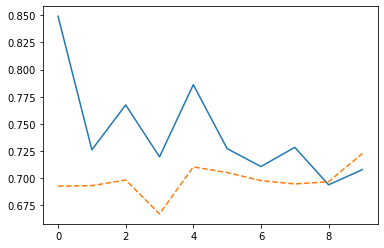

In [31]:
# Visualize train_stat
plt.plot(ls1)
plt.plot(ls2, linestyle='--')